<a href="https://colab.research.google.com/github/shumshersubashgautam/AutismClassification/blob/main/Autism_Research_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 74 Jan  8 09:35 kaggle.json


In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!pwd

/content


In [9]:
!kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                     COVID-19 Dataset                                     5MB  2022-11-13 15:47:17          16606        470  1.0              
devrimtuner/list-of-moststreamed-songs-on-spotify             Top 100 Spotify Songs👑🎤🎧🎼                            3KB  2022-12-30 05:42:54            856         43  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india  Credit Card Spending Habits in India               319KB  2022-12-14 07:30:37           2240         68  1.0              
die9origephit/fifa-world-cup-2022-complete-dataset            Fifa World Cu

In [10]:
!kaggle kernels output iravad/autism-prediction-cnn-vgg16-t-sne-visualisation -p /path/to/dest

Kernel log downloaded to /path/to/dest/autism-prediction-cnn-vgg16-t-sne-visualisation.log 


In [11]:
!pwd

/content


In [12]:
!mkdir autism

In [13]:
cd autism

/content/autism


In [14]:
!kaggle datasets download -d cihan063/autism-image-data

 98% 224M/229M [00:01<00:00, 138MB/s]
100% 229M/229M [00:01<00:00, 141MB/s]


In [15]:
!mv /content/autism/autism-image-data.zip /content/

### **1.Import libraries**

In [20]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as PathEffects
from PIL import Image, ImageDraw, ImageOps
%matplotlib inline
import seaborn as sns
import random
import os
import gc

from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers

from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D

from tensorflow.keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import img_to_array, load_img

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

**2.Get Training data**

We create file path for training and test data from the **"autism-image-data"**  : https://www.kaggle.com/datasets/cihan063/autism-image-data API: **!kaggle datasets download -d cihan063/autism-image-data**



In [33]:
# Creating file path for our train data and test data
train_dir = "/content/autism/AutismDataset/train"
test_dir = "/content/autism/AutismDataset/test"

In [18]:
cd ..

/content


We get the 'Autistic' and 'Non-Autistic' images from train data, shuffle them and use as training images
The dataset has 2450 train images, with 1225 images for each 'Autistic' and 'Non-Autistic' category, our dataset is well balanced among the 2 classes
We also get the 300 test images from file path

In [34]:

# Getting 'Autistic' and 'Non-Autistic' train images from respective file names of train data
train_non_autistic = []
train_autistic = []
for i in os.listdir(train_dir):
    if 'Non_Autistic' in ("/content/autism/AutismDataset/train/{}".format(i)):
        train_non_autistic.append(("/content/autism/AutismDataset/train/{}".format(i)))
    else:
        train_autistic.append(("/content/autism/AutismDataset/train/{}".format(i)))
        
# Getting test images from test data file path
test_imgs = ["/content/autism/AutismDataset/test/{}".format(i) for i in os.listdir(test_dir)]


# Concatenate 'Autistic'  and 'Non-Autistic' images and shuffle them as train_images
train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)

# Remove the lists to save space
del train_autistic
del train_non_autistic
gc.collect()

0

Let's see the training data samples.

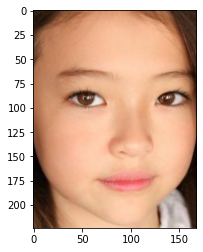

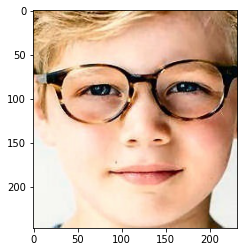

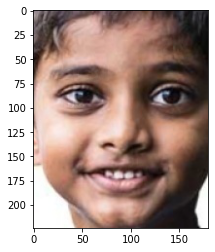

In [35]:
# Plot first 3 images from train_imgs
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

As we can see here, the train images are of different dimensions
The images need to be resized uniformly before feeding them to our model

In [36]:
# Set the dimensions for images
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    return X,y

## **3. Pre-processing Data**


*  Let's define the dimensions for resizing the images first
*  Then we write a function to read the images, resize them and specify the labels(y) for each image based on the file name - label '1' if 'Autistic' and label '0' if 'Non-Autistic'


*   X is the resized image and y is the class the image belongs to








In [37]:
# Get resized images and labels from train data
X_train, y_train = read_and_process_image(train_imgs)

In [38]:
# Convert the lists to array
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(12, 8))
X_train = np.array(X_train)
y_train = np.array(y_train)
#sns.countplot(y_train, saturation=1)
#plt.title("Train image labels");

<Figure size 864x576 with 0 Axes>

In [39]:
# Function for pre-processing images for input to t-sne algorithm
def process_data_tsne(list_of_images):
    
    """ Read and pre-process images to specified dimensions, separate image pixels and labels, convert the lists to numpy array
    
    Parameters:
    list_of_images: Input image data
    
    Returns:
    Numpy array of image pixels and labels
    """
    
    nrows = 150
    ncolumns  = 150
    channels = 3
    
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.COLOR_BGR2GRAY), (nrows, ncolumns)))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    X = np.asarray(X)
    y = np.asarray(y)
    X = X.reshape(2540, 150*150*3)
    
    return X,y

Call the function to read and resize train images, it returns X_train(train images) and y_train(train labels)

In [40]:
# Pre-process the image data and get the features and labels
features, labels = process_data_tsne(train_imgs)

In [41]:
# Perform t-sne on features
tsne = TSNE(random_state=42).fit_transform(features)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [42]:
# Function for plotting t-sne result as 3D data points
def visualise_tsne_3d(tsne_data, target):
    colour_map = []
    for i in target:
        if i == 1:
            colour_map.append('r')
        else:
            colour_map.append('b')

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*zip(*tsne), c=colour_map, s=30, alpha=1)
    legenditems = [(plt.Rectangle((0,0),1,1, color=c), "Non_Autistic" if str(i) == '0' else "Autistic") for i,c in enumerate(np.unique(colour_map))]
    plt.legend(*zip(*legenditems))
    plt.show()

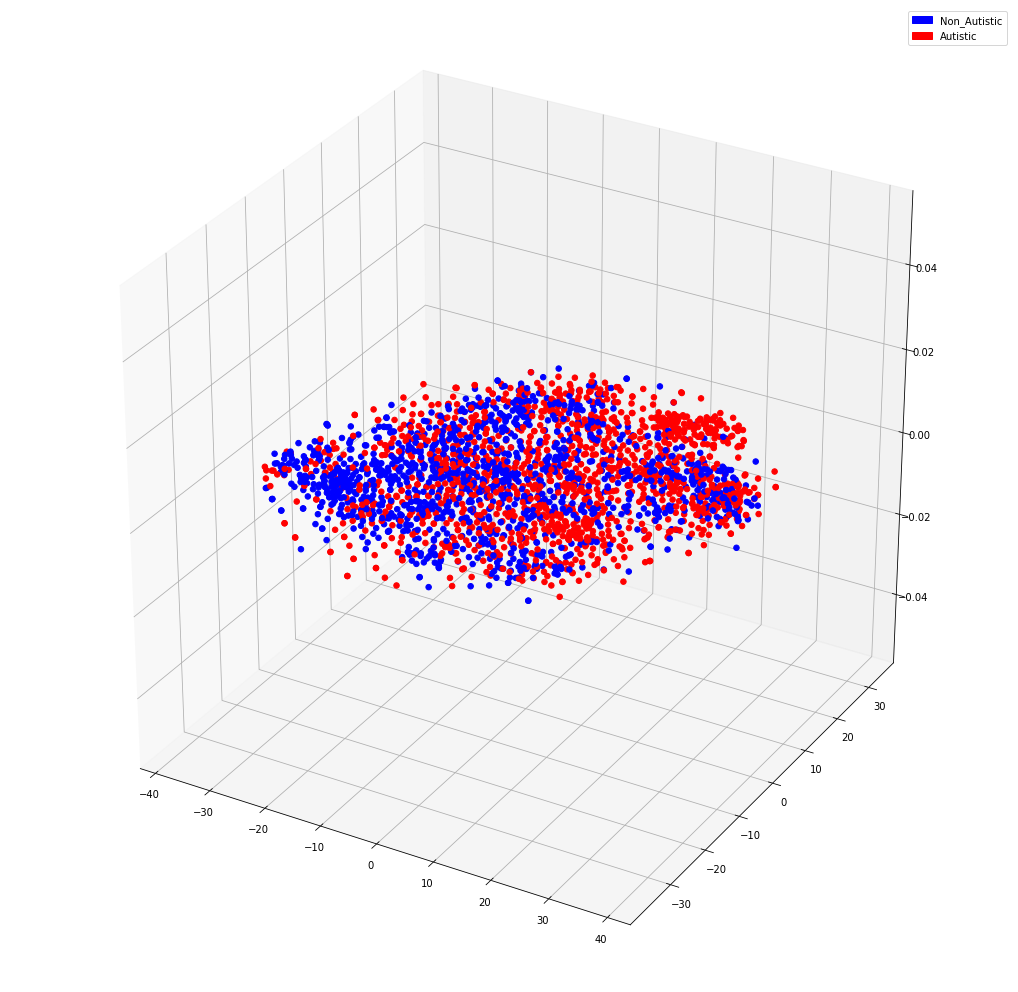

In [43]:
# Visualise t-sne result in 3D
visualise_tsne_3d(tsne, labels)

In [44]:
# Function for plotting t-sne result as data points
def visualise_tsne_datapoints(tsne_data, labels):
    
    """Takes in tsne projections, plots distribution of datapoints in 2 classes"""
    
    tx = tsne_data[:,0]
    ty = tsne_data[:,1]
    plt.figure(figsize=(20,18))
    sns.scatterplot(
    x=tx, y=ty,
    hue=labels,
    palette=['blue', 'red'],
    s=300, 
    legend='auto'
    )

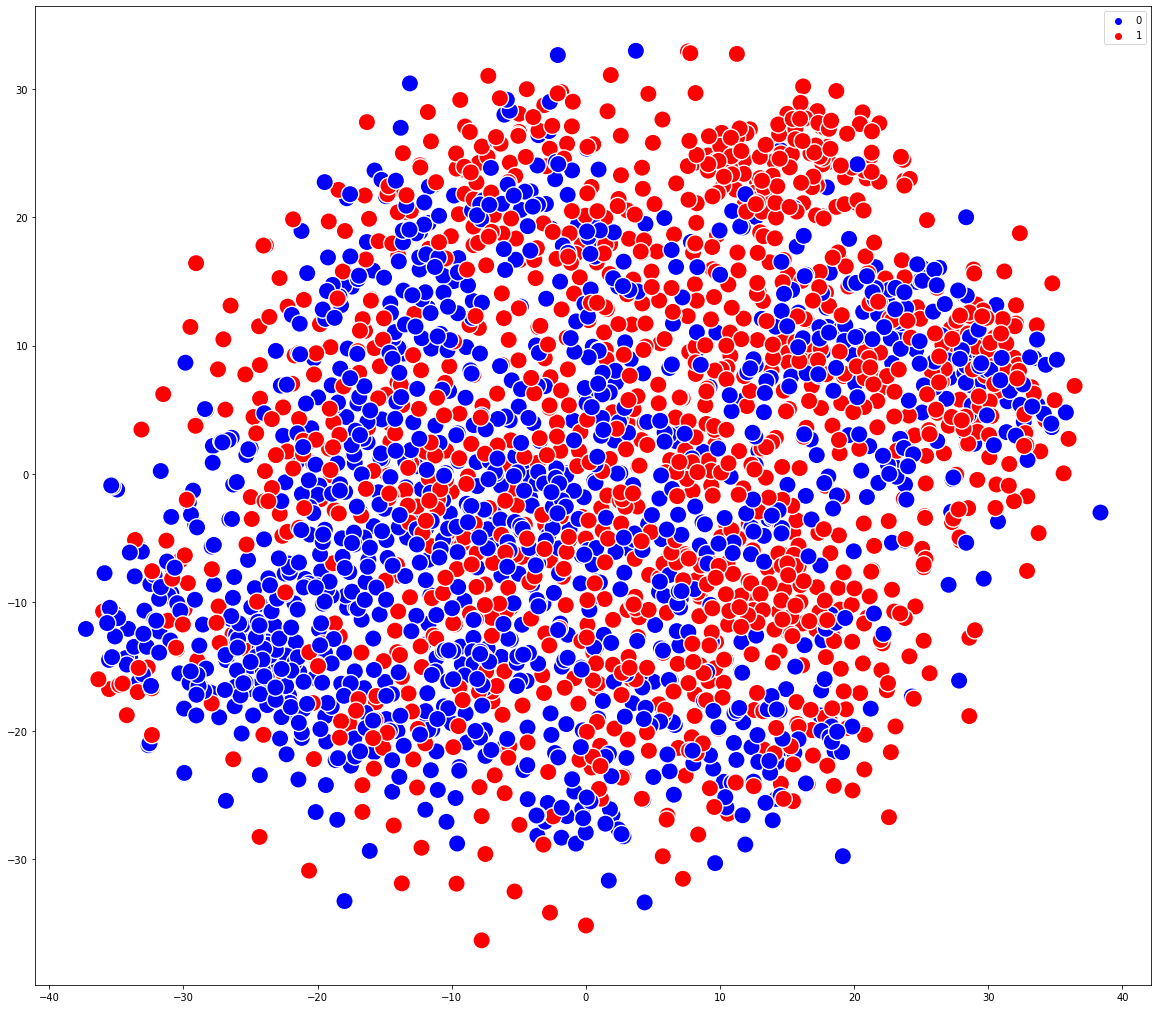

In [45]:
# Visualise class data points in 2 dimensional space
visualise_tsne_datapoints(tsne,labels)

In [46]:
# Function to plot t-sne result as images
def visualise_tsne_images(tsne_data, train_images, labels):
    
    """Takes in tsne projections, plots distribution of images in 2 classes"""
    
    tx = tsne_data[:,0]
    ty = tsne_data[:,1]
    image_paths = [train_images[i] for i in range(len(train_images))]
    #label = y_train

    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

    width = 4000
    height = 3000
    max_dim = 200

    full_image = Image.new('RGBA', (width, height))
    for img, x, y, label in zip(image_paths, tx, ty, labels):
        tile = Image.open(img)
        rs = max(1, tile.width/max_dim, tile.height/max_dim)
        tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
        tile_height, tile_width = tile.size
        draw = ImageDraw.Draw(tile)
        draw.rectangle((0,0,tile_height-1,tile_width-1), fill=None, outline='blue' if label==0 else 'red', width=8)
        full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*(1-y))), mask=tile.convert('RGBA'))   
    plt.figure(figsize = (30,28))
    plt.imshow(full_image)

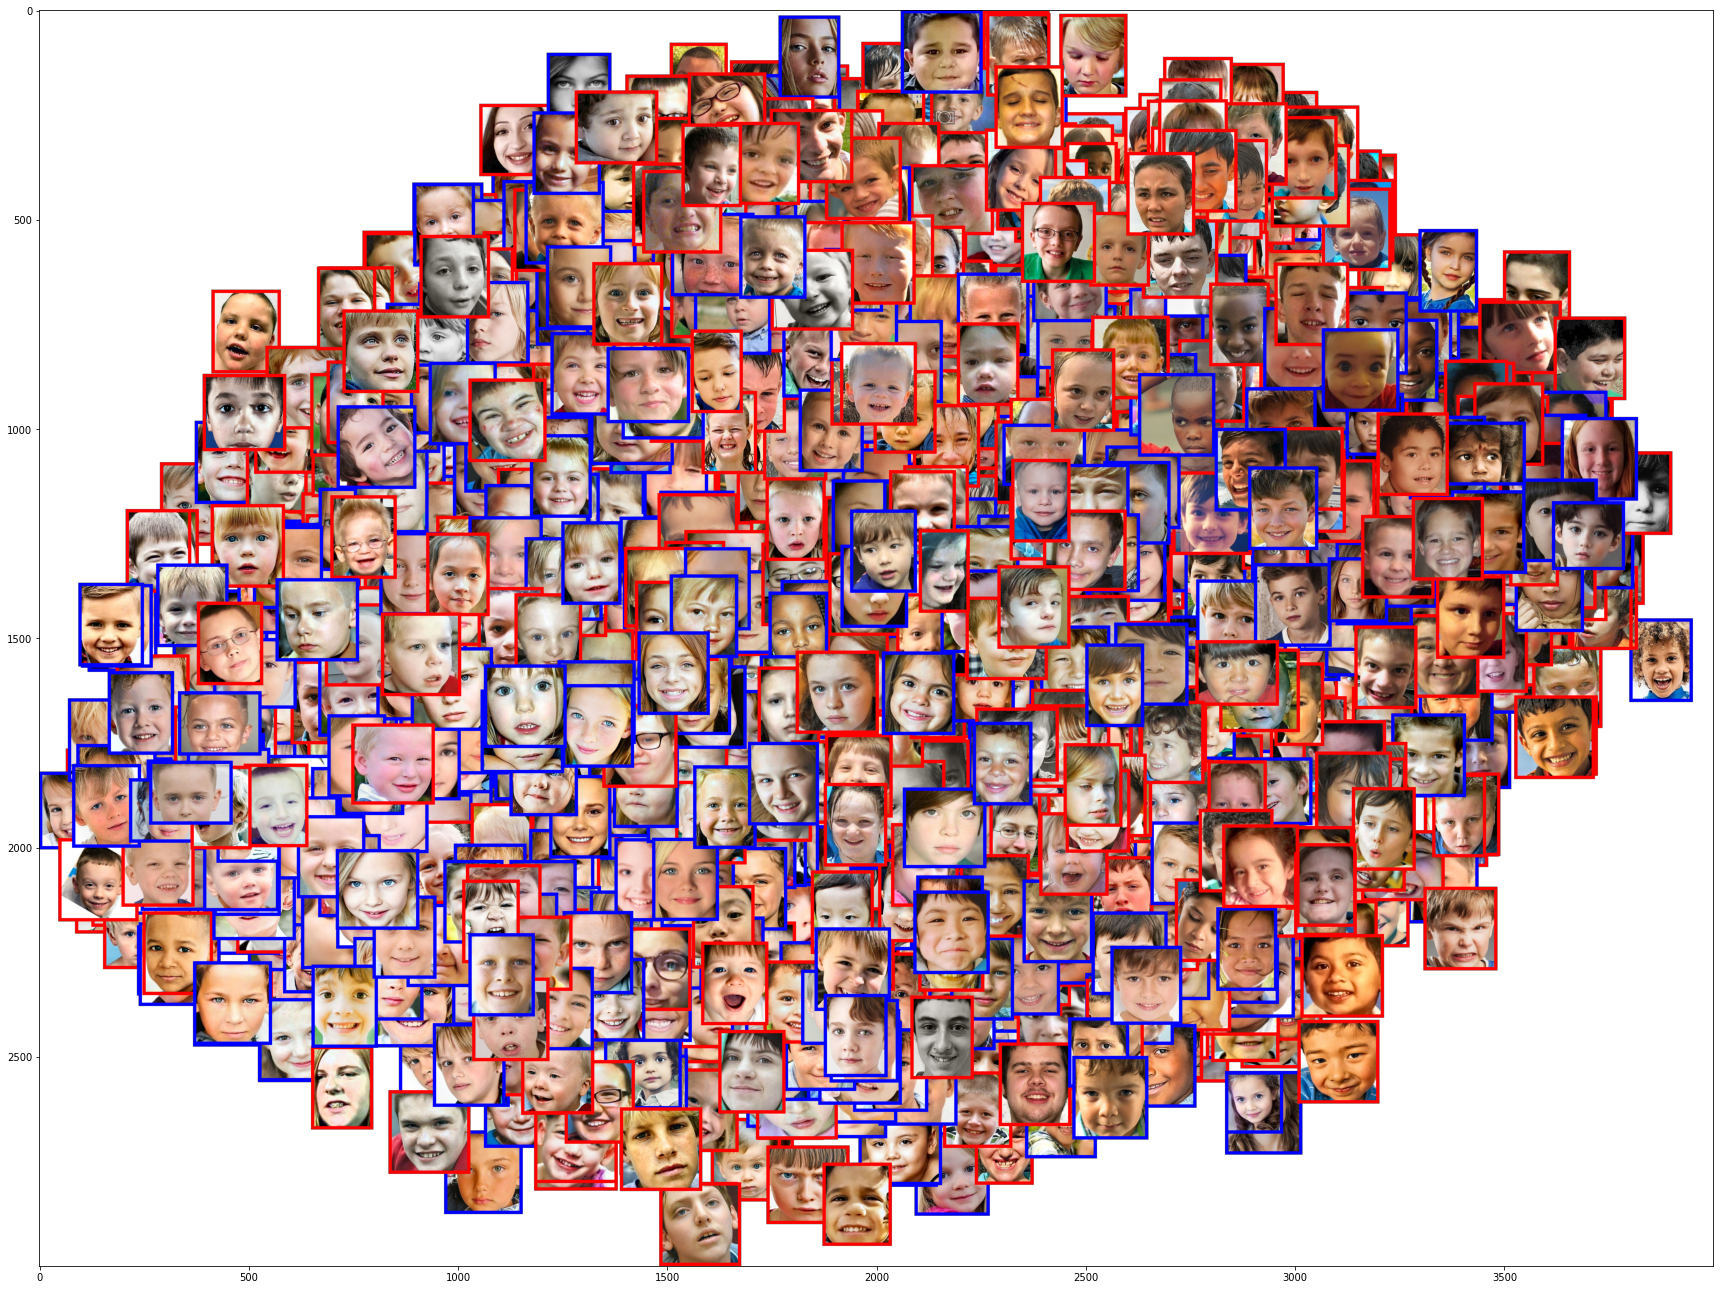

In [47]:
# Visualise class images in 2 dimesional space
visualise_tsne_images(tsne, train_imgs, labels)

In [48]:
# Shape of train images and labels
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 150, 150, 3)
Shape of train labels: (2540,)


In [51]:
# Repeat the above process for validation data to get val_images
val_autistic = "/content/autism/AutismDataset/valid/Autistic"
val_non_autistic = "/content/autism/AutismDataset/valid/Non_Autistic"
val_autistic_imgs = ["/content/autism/AutismDataset/valid/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = ["/content/autism/AutismDataset/valid/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

# Remove the lists to save space
del val_autistic_imgs
del val_non_autistic_imgs
gc.collect()

13900

In [52]:
# Get resized images and labels from validation data
X_val, y_val = read_and_process_image(val_imgs)

# Delete validation images to save space
del val_imgs
gc.collect()

0

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Validation image labels')

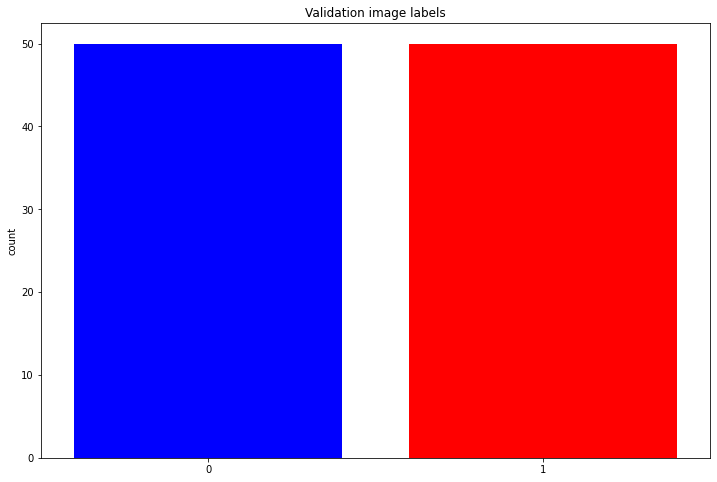

In [53]:
# Convert the lists to array
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(12, 8))
X_val = np.array(X_val)
y_val = np.array(y_val)
sns.countplot(y_val, saturation=1)
plt.title("Validation image labels")

In [54]:
# Shape of validation images and labels
print("Shape of validation images:", X_val.shape)
print("Shape of validation labels:", y_val.shape)

Shape of validation images: (100, 150, 150, 3)
Shape of validation labels: (100,)


In [55]:
# Get length of train data and validation data
ntrain = len(X_train)
nval = len(X_val)
BATCH_SIZE = 32

In [56]:
# Calling pre-trained VGG16 model
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))

58889256/58889256 [==============================] - 1s 0us/step


In [57]:
# Freeze the layers in pre-trained model, we don't need to train again
for layer in base_model.layers:
   layer.trainable = False

In [58]:
# Let's see how many layers are in the vgg model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [59]:
# Create our classifier model, connect pre-trained model vgg to our model
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [60]:
# Create summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [61]:
# Compile the model specifying optimizer, loss function and metrics
model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics = ['acc'])

In [62]:
# Configure data augumentation and scaling of images to prevent overfitting since we have a small train data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

# Only rescaling for validation data
val_datagen = ImageDataGenerator(rescale = 1./255)

In [63]:
# Create test and validation image generator
train_generator = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size = BATCH_SIZE)

In [64]:
# Tune the model based on the validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Train the model
history = model.fit(train_generator,
                              epochs=30,
                              validation_data=val_generator,
                              callbacks=[early_stopping],
                              workers=4,
                              use_multiprocessing=False
                             )

Epoch 1/30
80/80 [==============================] - 631s 8s/step - loss: 0.8820 - acc: 0.6091 - val_loss: 0.5385 - val_acc: 0.7200
Epoch 2/30
80/80 [==============================] - 612s 8s/step - loss: 0.5594 - acc: 0.7035 - val_loss: 0.5305 - val_acc: 0.7500
Epoch 3/30
80/80 [==============================] - 634s 8s/step - loss: 0.5557 - acc: 0.7110 - val_loss: 0.5254 - val_acc: 0.7500
Epoch 4/30
80/80 [==============================] - 611s 8s/step - loss: 0.5290 - acc: 0.7224 - val_loss: 0.5100 - val_acc: 0.7700
Epoch 5/30
80/80 [==============================] - 626s 8s/step - loss: 0.5314 - acc: 0.7311 - val_loss: 0.5523 - val_acc: 0.7000
Epoch 6/30
80/80 [==============================] - 604s 8s/step - loss: 0.5154 - acc: 0.7406 - val_loss: 0.5206 - val_acc: 0.7300
Epoch 7/30
80/80 [==============================] - 606s 8s/step - loss: 0.5175 - acc: 0.7390 - val_loss: 0.5075 - val_acc: 0.7500
Epoch 8/30
80/80 [==============================] - 624s 8s/step - loss: 0.5231 - a

In [65]:
# Learning curves for training and validation
history_df = pd.DataFrame(history.history)
history_df

loss       acc  val_loss  val_acc
0   0.881952  0.609055  0.538475     0.72
1   0.559419  0.703543  0.530453     0.75
2   0.555678  0.711024  0.525384     0.75
3   0.529043  0.722441  0.510022     0.77
4   0.531398  0.731102  0.552252     0.70
5   0.515354  0.740551  0.520612     0.73
6   0.517516  0.738976  0.507516     0.75
7   0.523092  0.733071  0.497121     0.76
8   0.522996  0.740157  0.506307     0.77
9   0.507947  0.745669  0.494280     0.76
10  0.505665  0.741339  0.496411     0.74
11  0.510362  0.740551  0.516685     0.75
12  0.502329  0.751575  0.510304     0.79

Text(0.5, 1.0, 'Training and Validation Accuracy')

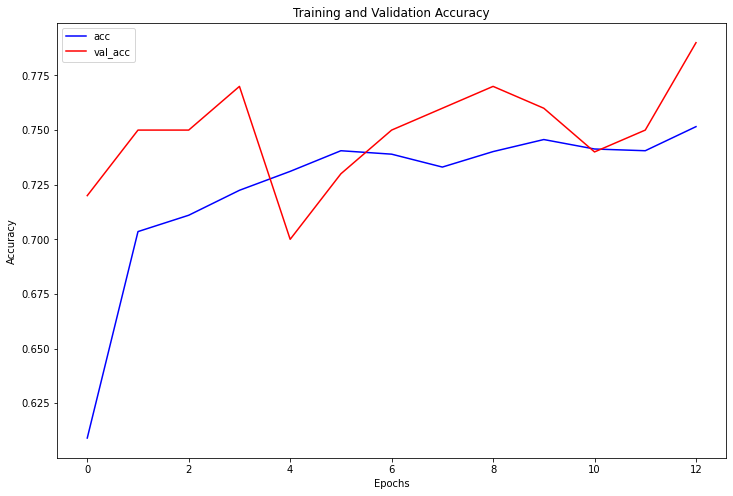

In [66]:
# Plot train and validation accuracy
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["acc", "val_acc"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

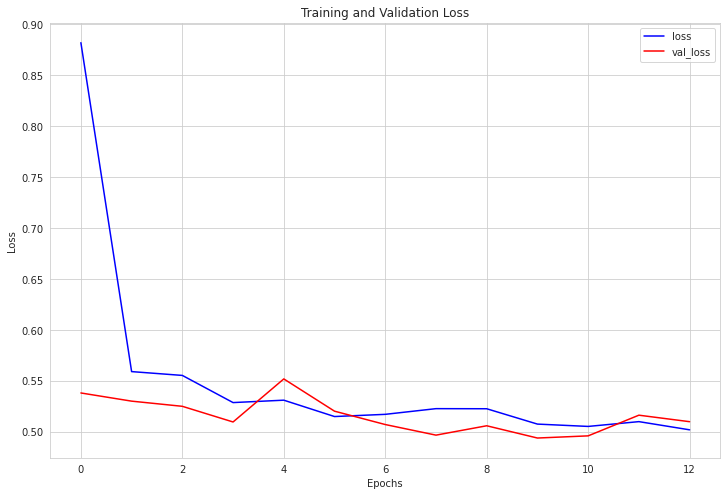

In [67]:
# Plot train and validation loss
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

In [68]:
# Function to get the features from the last hidden layer of neural network
def get_features(trained_model, validation_data):
    
    def get_truncated_model(trained_model):
    
        """Takes in the model, Returns truncated model without classification layer"""
        
        model = keras.models.Sequential()
        model.add(base_model)
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation = 'relu'))
        
        for i, layer in enumerate(model.layers):
            layer.set_weights(trained_model.layers[i].get_weights())
            
        model.compile(optimizer = keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
        return model

    # Get truncated model
    truncated_model = get_truncated_model(model)
    
    # Use truncated model to predict features from the last hidden layer
    features = truncated_model.predict(validation_data)
        
    return features

In [69]:
# Get features of NN from the last hidden layer 
features = get_features(model, val_generator)

4/4 [==============================] - 23s 5s/step


In [70]:
# Perform tsne on the features of the last hidden layer
tsne_model = TSNE(random_state=42, perplexity=4).fit_transform(features)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


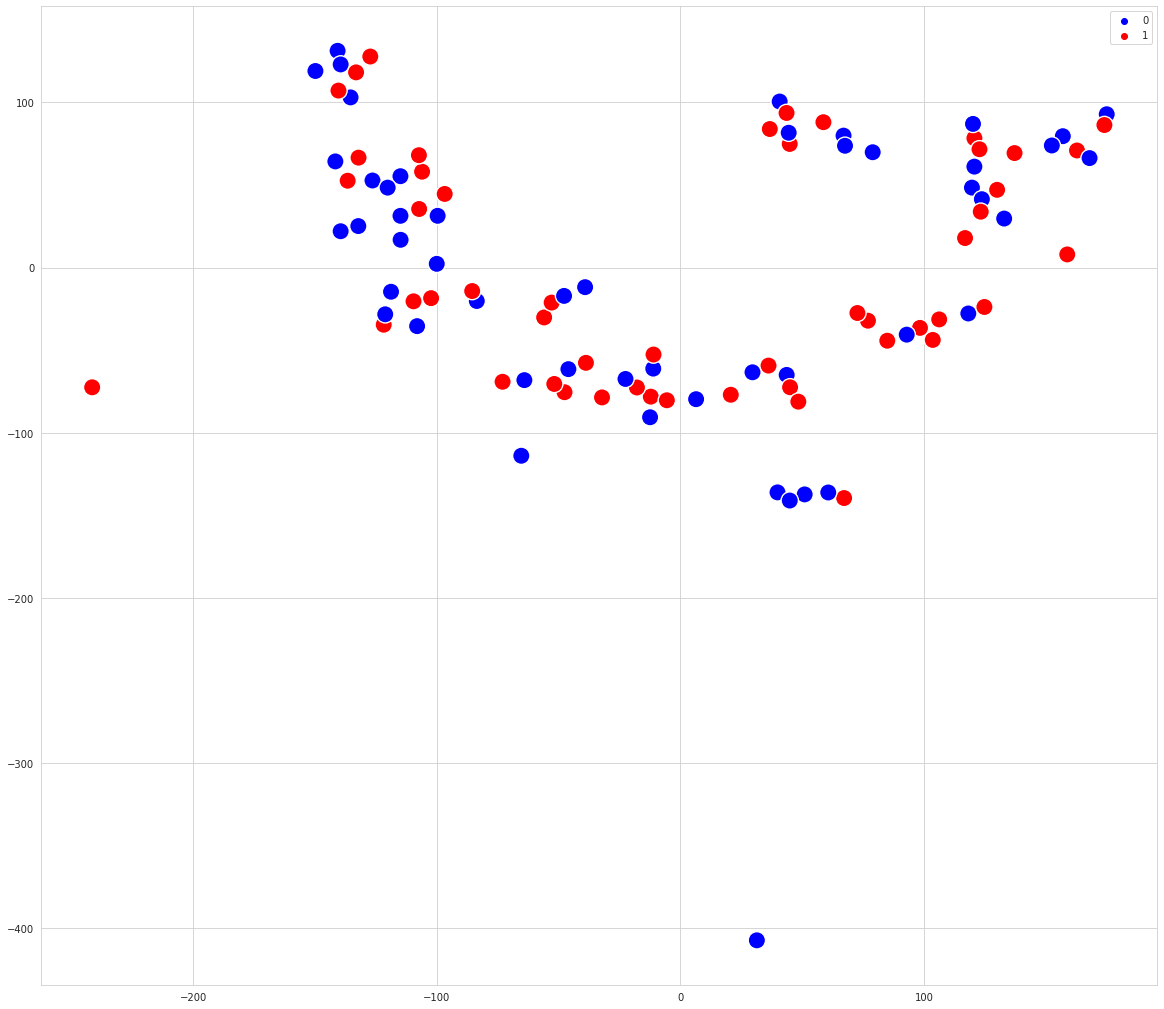

In [71]:
# Visualise the 2 dimensional projection of 512 dimensional features from the last hidden layer
visualise_tsne_datapoints(tsne_model, y_val)

In [72]:
# Function to plot 3D tsne data
def visualise_model_tsne_3d(tsne_model, val_labels):
    colour_map = [] 
    for i in val_labels: 
        if i == 1: 
            colour_map.append('r') 
        else: 
            colour_map.append('b')

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*zip(*tsne_model), c=colour_map, s=50, alpha=1)
    legenditems = [(plt.Rectangle((0,0),1,1, color=c), "Non_Autistic" if str(i) == '0' else "Autistic") for i,c in enumerate(np.unique(colour_map))]
    plt.legend(*zip(*legenditems))
    plt.show()

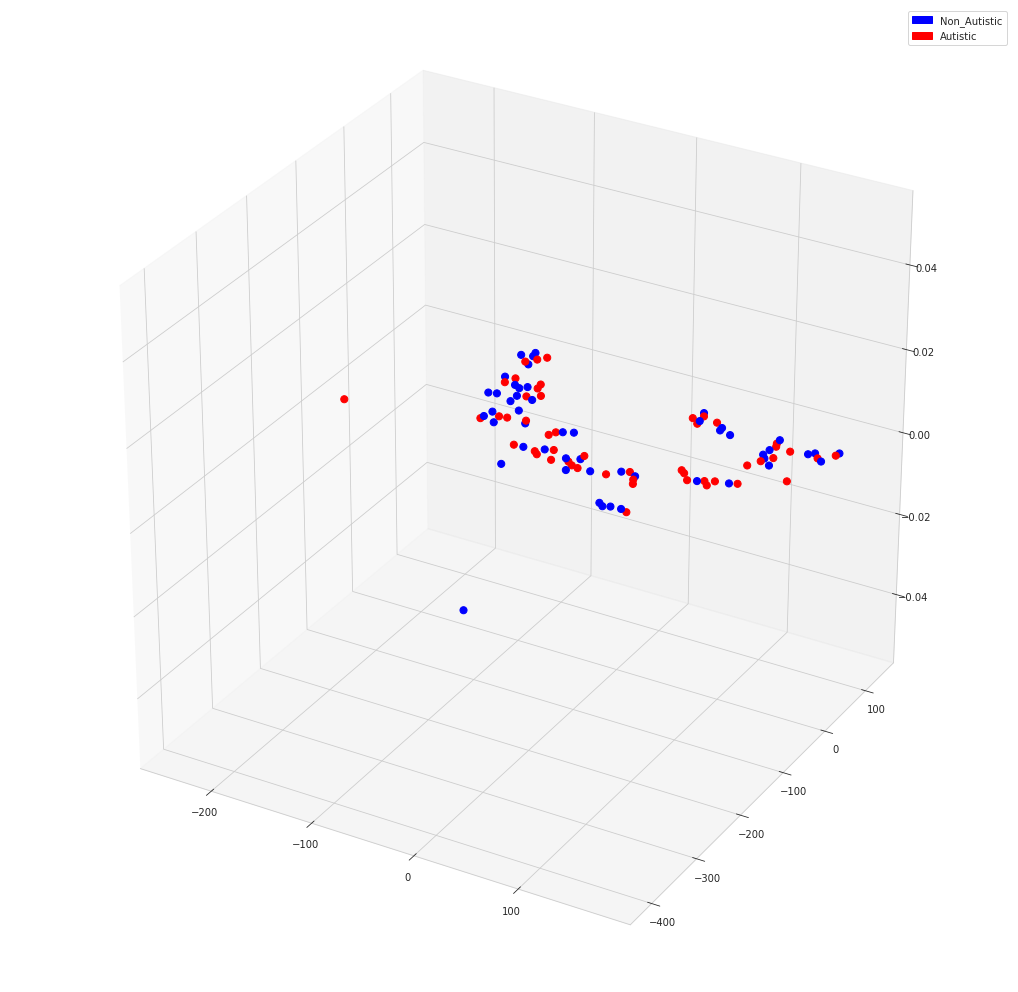

In [73]:
# Visualise the 3 dimensional projection of 512 dimensional features from the last hidden layer
visualise_model_tsne_3d(tsne_model, y_val)

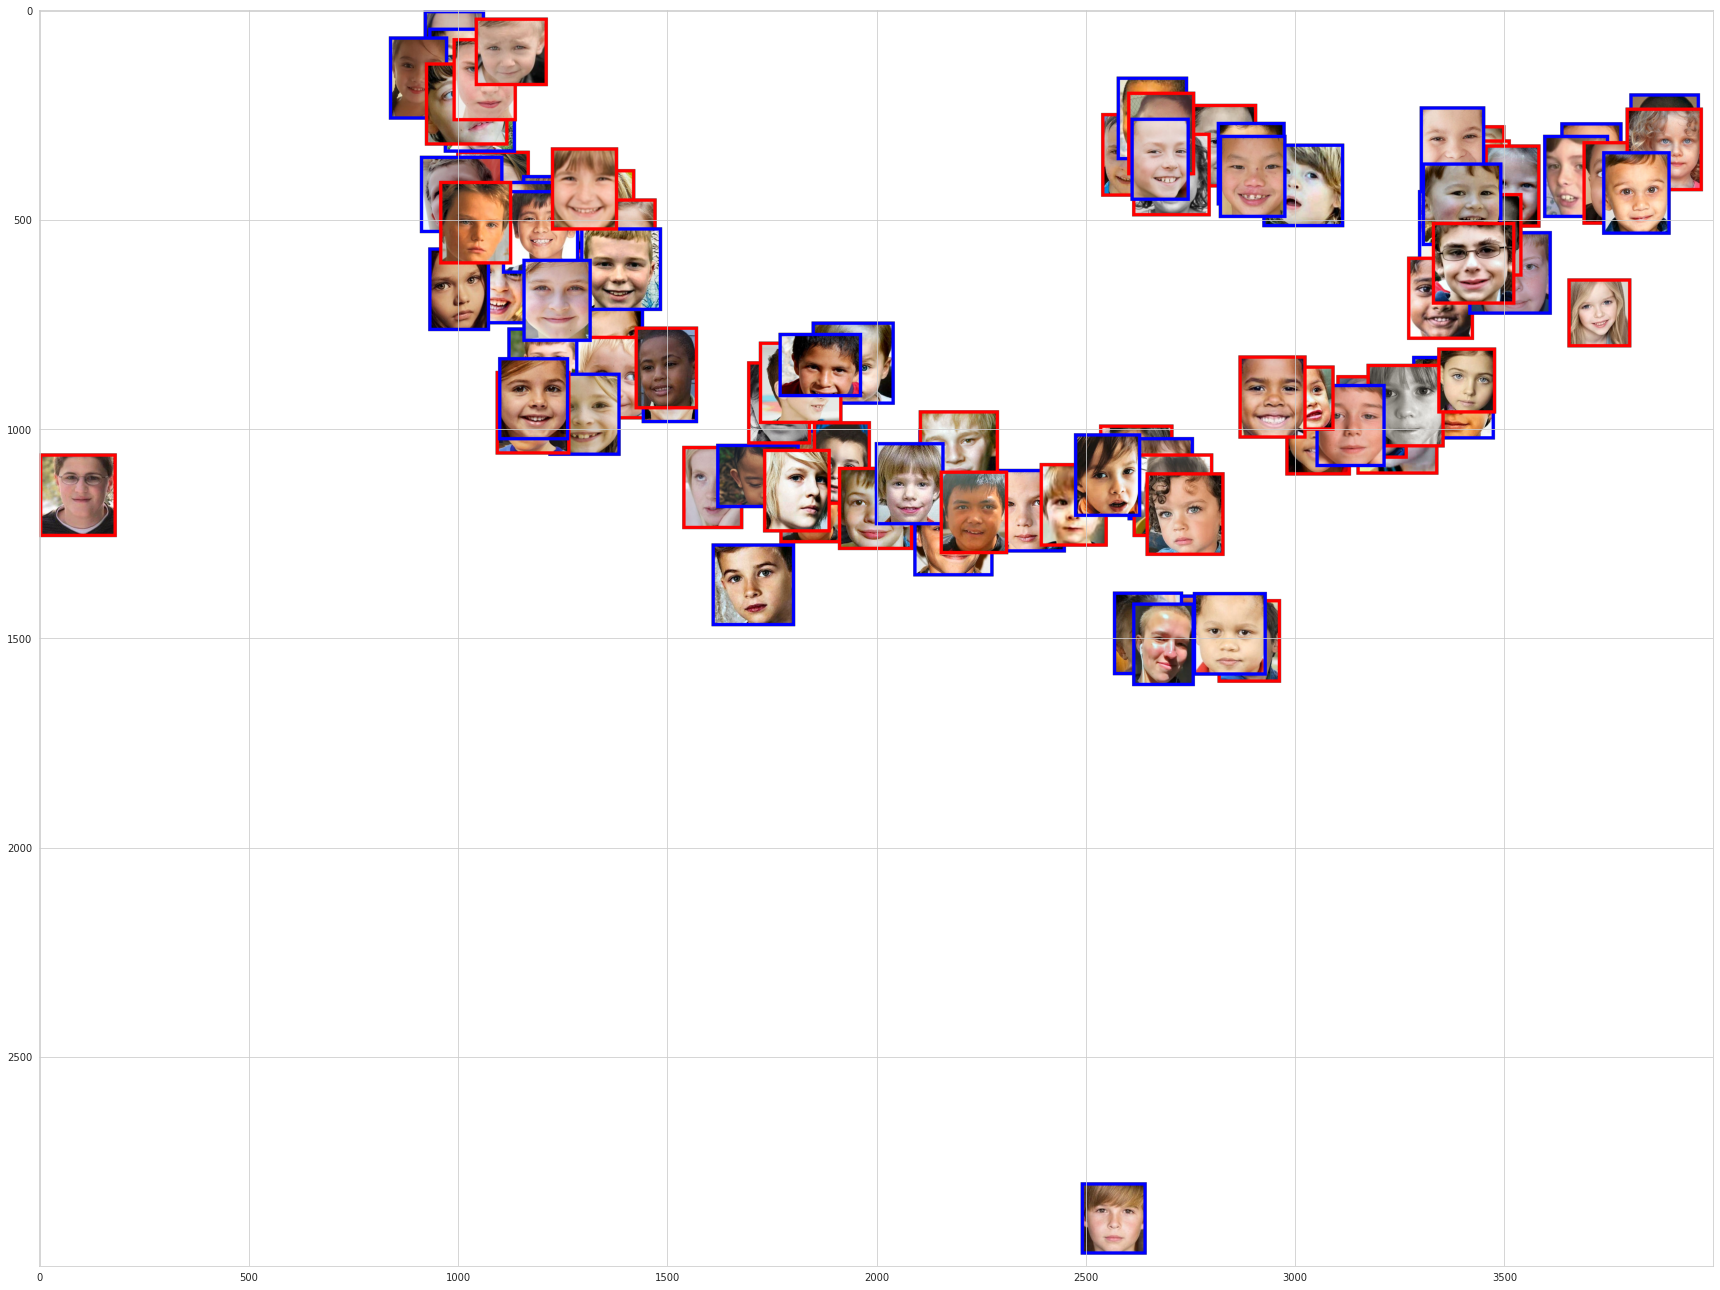

In [74]:
# Visualise the image grouping in the last hidden layer
visualise_tsne_images(tsne_model, train_imgs, y_val)

In [75]:
# Read and resize test images
random.shuffle(test_imgs)
X_test, y_test = read_and_process_image(test_imgs)
X = np.array(X_test)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


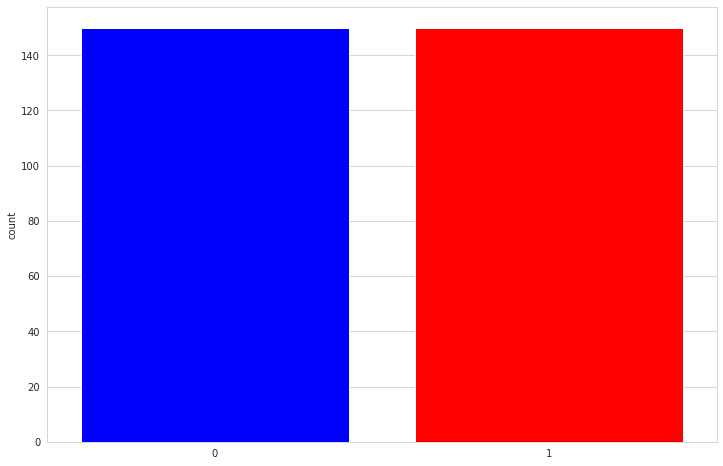

In [76]:
# Plotting the test label count in each class
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(12, 8))
sns.countplot(y_test, saturation=1);

In [77]:
# Predict label for test images
pred = model.predict(X)
threshold = 0.5
predictions = np.where(pred > threshold, 1,0)

10/10 [==============================] - 71s 7s/step


In [78]:
# Plot test images and their corresponding predictions
test = pd.DataFrame(data = predictions, columns = ["predictions"])
test
test["filename"] = [os.path.basename(i) for i in test_imgs]
test["test_labels"] = y_test
test = test[["filename", "test_labels", "predictions"]]
test

filename  test_labels  predictions
0     Non_Autistic.55.jpg            0            1
1        Autistic.140.jpg            1            0
2         Autistic.72.jpg            1            1
3         Autistic.83.jpg            1            1
4         Autistic.36.jpg            1            1
..                    ...          ...          ...
295    Non_Autistic.5.jpg            0            0
296  Non_Autistic.129.jpg            0            0
297  Non_Autistic.149.jpg            0            0
298  Non_Autistic.104.jpg            0            0
299       Autistic.61.jpg            1            0

[300 rows x 3 columns]

In [79]:
model_accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy: {:.2f}%".format(model_accuracy * 100))


Model Accuracy: 70.33%


In [80]:
# Generating Classification report for model's performance in each class
cl_report = classification_report(y_test, predictions)
print(cl_report)

              precision    recall  f1-score   support

           0       0.65      0.87      0.74       150
           1       0.80      0.54      0.65       150

    accuracy                           0.70       300
   macro avg       0.73      0.70      0.70       300
weighted avg       0.73      0.70      0.70       300



In [81]:
# Generating Confusion Matrix for the predictions against true labels
cn_matrix= confusion_matrix(y_test, predictions)
cn_matrix

array([[130,  20],
       [ 69,  81]])

Text(0.5, 1.0, 'Confusion Matrix')

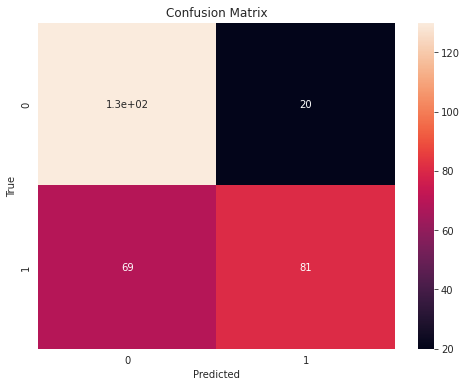

In [82]:
# Plotting the True Positives, True Negatives, False Positives and False Negatives from model's predictions
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [83]:
# Let's plot the AUC-ROC curve to assess the performance of our model
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc= auc(fpr, tpr)

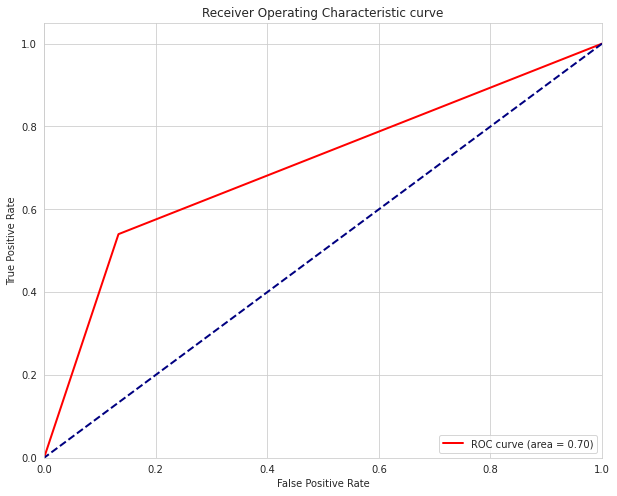

In [84]:
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, color = 'red', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([1,0], [1,0], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc = 'lower right')

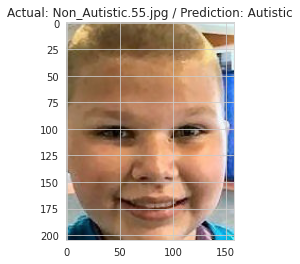

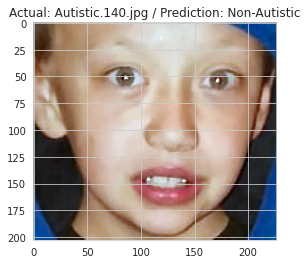

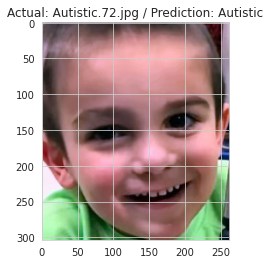

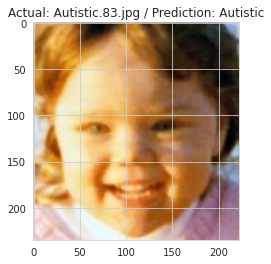

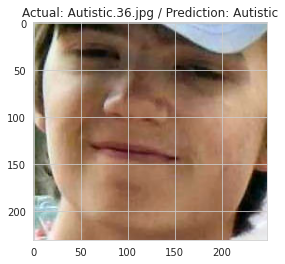

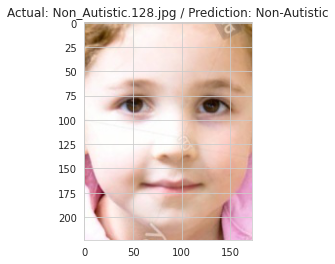

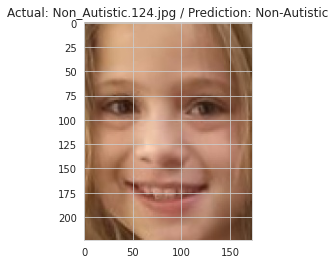

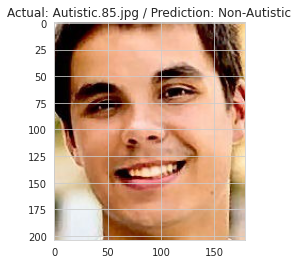

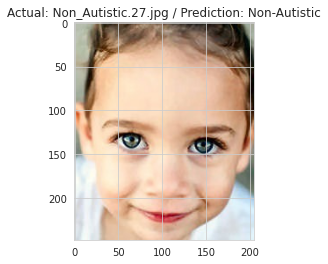

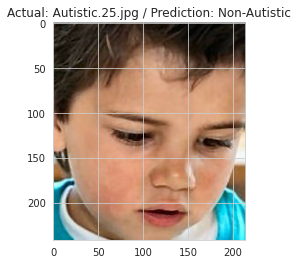

In [85]:
# Let's check our predcitions against some test images
plt.figure(figsize=(4,4))
for val, i in enumerate(test_imgs[:10]):
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.title('Actual: ' + os.path.basename(i) + ' / Prediction: ' +  f"{'Autistic' if predictions[val] == 1 else 'Non-Autistic'}")
    plt.show()